In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import os

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn import metrics
import plotnine as pn

In [3]:
%matplotlib inline

In [4]:
!ls glioma_cancer*.csv

glioma_cancer_exprs.csv
glioma_cancer_metadata.csv


In [5]:
expression_data = pd.read_csv('glioma_cancer_exprs.csv', index_col=0)
metadata = pd.read_csv('glioma_cancer_metadata.csv')

In [6]:
expression_data.iloc[:, :5].head()

,GSM3242216,GSM3242217,GSM3242218,GSM3242219,GSM3242220
A1BG,5.515270,5.395054,5.456711,5.418592,5.632935
A1CF,5.424709,5.297825,5.125438,5.295408,5.254164
A2M,10.855696,10.855696,12.175815,12.665022,11.359839
A2ML1,5.239263,5.016883,4.994302,5.035702,5.271587
A4GALT,5.007046,4.822156,6.029816,5.481442,5.154528


In [7]:
expression_data.T.iloc[:, :50:5].head()

,A1BG,AAAS,AANAT,AASS,ABCA12,ABCA6,ABCB10,ABCB7,ABCC12,ABCC9
GSM3242216,5.515270,6.482492,3.587834,7.965020,3.904950,4.673120,8.679417,8.961986,4.170356,5.959392
GSM3242217,5.395054,6.800803,3.625262,7.643842,3.996264,4.287302,8.216042,8.000840,4.181801,5.822909
GSM3242218,5.456711,7.206842,3.632422,7.937114,4.035082,4.818347,7.976309,7.958780,4.071721,5.920405
GSM3242219,5.418592,7.392528,3.540191,8.121360,3.945085,4.691893,7.922070,8.528078,4.125024,5.705961
GSM3242220,5.632935,7.439305,3.785457,7.727435,3.987541,4.668900,8.552964,8.405311,4.213534,5.801042


In [8]:
# load in differential gene result for normal vs cancer cells
norm_canc_dge = pd.read_csv('normal_vs_cancer_DGE_result.csv', index_col=0)
norm_canc_dge.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
PRSS3,-2.765356,5.816032,-33.123687,1.629749e-153,2.069618e-149,340.254416
SVOP,-4.555511,6.012391,-31.965505,2.354789e-146,1.495173e-142,323.820933
CYP4X1,-3.688198,5.692362,-31.577010,6.031425e-144,2.553102e-140,318.292683
FRMPD4,-3.836425,5.672352,-31.061808,9.524388e-141,3.023755e-137,310.951057
CPNE9,-2.581998,5.307128,-30.823067,2.900563e-139,7.366849e-136,307.545444


In [9]:
# getting differential genes
selected_genes = norm_canc_dge.index.tolist()

In [10]:
# selecting genes in expression data
expression_data = expression_data.loc[selected_genes,:]

In [11]:
# transpose expression data
expression_data = expression_data.T

In [12]:
# checking if positions of samples in metadata corresponds with that in expression data
all(metadata.sample_id == expression_data.index)

True

### __Splitting into train and test__

In [13]:
# encode normal samples as 0 and cancer samples as 1
target_var = pd.Series(np.where(metadata.tumor_type == 'Normal', 0, 1))

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(expression_data, 
                                                target_var, 
                                                test_size=0.25,
                                                stratify=target_var,
                                                random_state=43)

__Helper functions__

In [15]:
def tune_parameters(model, X, y, param_grid, scorer='roc_auc', cv=5):
    gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scorer)
    gcv.fit(X, y)
    return gcv

In [16]:
def print_classification_report(model, X, y):
    preds = model.predict(X)
    print(metrics.classification_report(y, preds, target_names=['Normal', 'Tumour']))

def eval_metrics(model, X, y):
    preds = model.predict(X)
    probs = model.predict_proba(X)[:,1]
    acc = np.mean(y == preds)
    auc = metrics.roc_auc_score(y, probs)
    rec = metrics.recall_score(y, preds)
    prec = metrics.precision_score(y, preds)
    f1 = metrics.f1_score(y, preds)
    spec = np.sum((preds == 0) & (y == 0)) / np.sum(y==0)

    scores = pd.DataFrame([acc, auc, rec, prec, f1, spec], 
                          columns=['scores'], 
                          index=['Accuracy', 'AUC', 'Recall', 
                                 'Precision', 'F1', 'Specificity'])
    return scores.T

In [17]:
def performance_chart_report(model, X, y):
    fig, ax = plt.subplots(1,3, figsize=(12,5))
    _ = metrics.RocCurveDisplay.from_estimator(model, X, y, ax=ax[0])
    _ = metrics.PrecisionRecallDisplay.from_estimator(model, X, y, ax=ax[1])
    _ = metrics.ConfusionMatrixDisplay.from_estimator(model, X, y, display_labels=['Normal', 'Tumour'], 
                                                    ax=ax[2], cmap ='Greens', colorbar=False)
    plt.suptitle(model.__class__.__name__, y=0.83, fontweight='bold')
    fig.tight_layout()
    #plt.show()

In [18]:
def topn_importance(model, topn=20):
    if hasattr(model, 'coef_'):
        varimp = model.coef_.squeeze()
        varimp = pd.Series(varimp, model.feature_names_in_).abs()
    elif hasattr(model, 'feature_importances_'):
        varimp = model.feature_importances_
        varimp = pd.Series(varimp, model.feature_names_in_)

    if topn is not None:
        varimp = varimp.nlargest(topn)
    varimp = varimp[varimp != 0] 
    varimp = varimp.reset_index(name='scores')
    varimp = varimp.rename(columns={'index':'gene'})

    fig = (
        pn.ggplot(varimp, pn.aes('reorder(gene, scores)', 'scores')) +
        pn.geom_col(fill='indianred') +
        pn.geom_text(pn.aes(label='scores'), fontweight='bold', size=8, 
                     format_string='{:.3f}', color='white', 
                     nudge_y=-max(varimp.iloc[:, 1])*0.05) + 
        pn.theme_bw() +
        pn.theme(panel_grid=pn.element_blank(),
                 figure_size=(7,4.5),
                 axis_title=pn.element_text(size=9),
                 axis_text=pn.element_text(size=8),
                 axis_text_x = pn.element_blank(),
                 axis_ticks_x = pn.element_blank(),
                 plot_title=pn.element_text(face='bold', hjust=0, size=12)) +
        pn.coord_flip() +
        pn.labs(title=model.__class__.__name__, 
                x='', y='scores')
        )
    return(fig)

### __Feature selection__

- Using Lasso logistic regression method
- Using a random forest model to recursively select features until feature importance scores are above zero.

__Logistic Regression__

In [19]:
lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, C=1, random_state=23)

In [20]:
lr_model = Pipeline([('scaler', StandardScaler()),
                      ('model', lr)])

lambdas = {'model__C' : [0.001, 0.01, 0.1, 0.5, 1]}

In [21]:
lr_res = tune_parameters(lr_model, xtrain, ytrain, lambdas)

In [22]:
lr_res.cv_results_['mean_test_score']

array([0.5       , 0.95851253, 0.99831141, 0.99882045, 0.99934469])

In [23]:
lr_res.best_params_

{'model__C': 1}

In [24]:
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = pd.DataFrame(scaler.transform(xtrain), 
                             columns=xtrain.columns, 
                             index=xtrain.index)

xtest_scaled = pd.DataFrame(scaler.transform(xtest), 
                            columns=xtest.columns, 
                            index=xtest.index)

In [25]:
lr.fit(xtrain_scaled, ytrain)

LogisticRegression(C=1, max_iter=500, penalty='l1', random_state=23,
                   solver='liblinear')

In [26]:
expression_data.shape[1] - sum(lr.coef_.squeeze() == 0)

83

In [27]:
lr_coefs = pd.Series(lr.coef_.ravel(), index=selected_genes)
lr_coefs = lr_coefs[lr_coefs != 0]
lr_coefs.shape

(83,)

- A total of 83 genes were selected

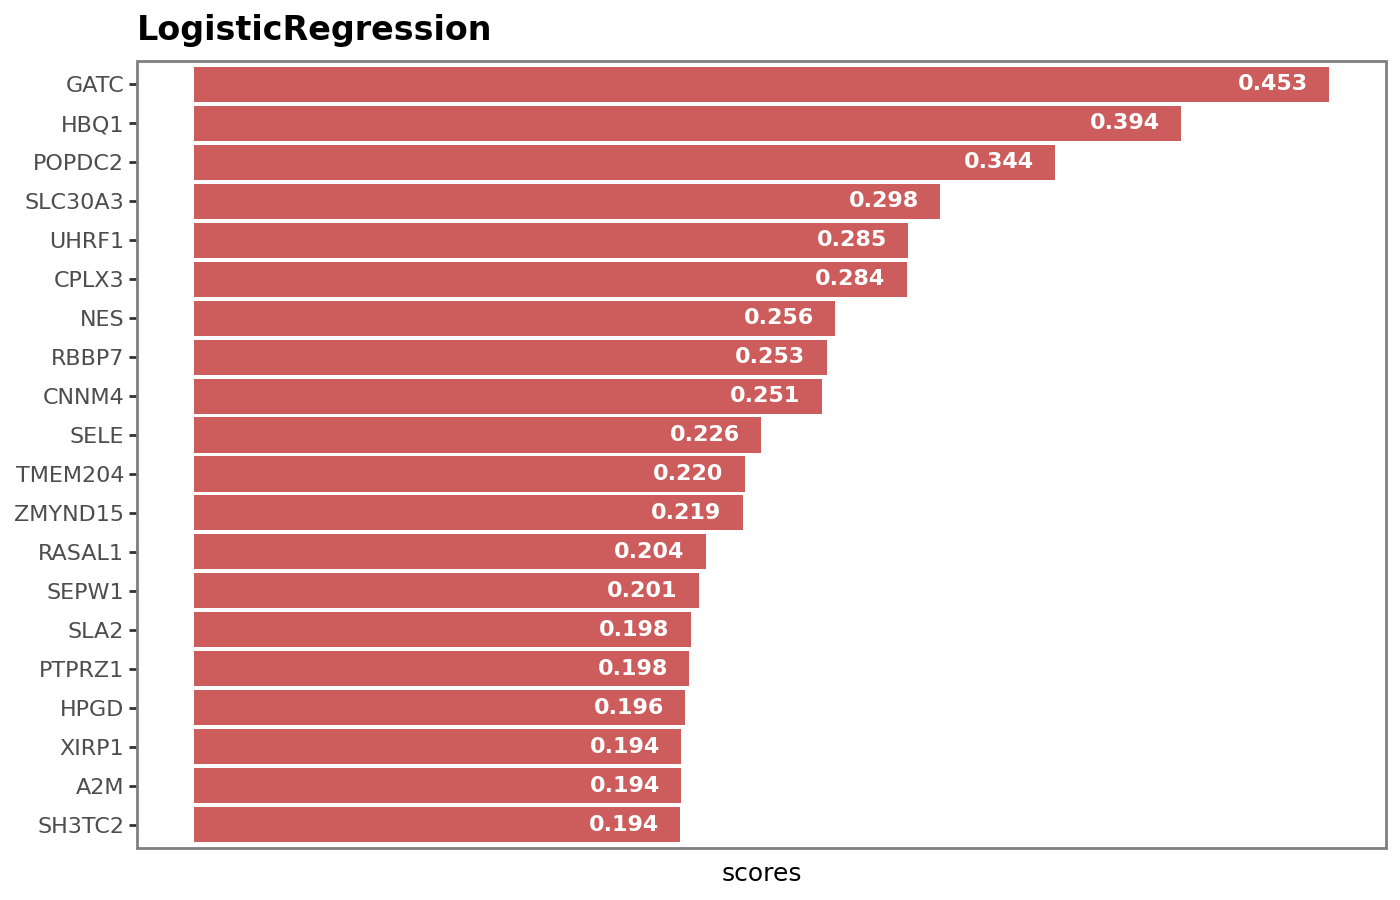

In [28]:
topn_importance(lr)

In [29]:
print(eval_metrics(lr, xtest_scaled, ytest))

        Accuracy       AUC    Recall  Precision       F1  Specificity
scores  0.980583  0.998168  0.983516   0.994444  0.98895     0.958333


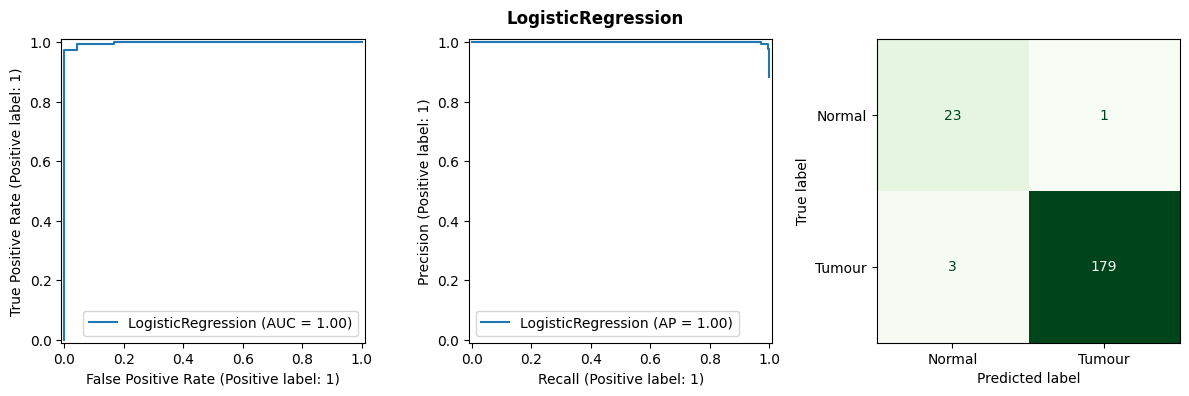

In [30]:
performance_chart_report(lr, xtest_scaled, ytest)

In [31]:
print_classification_report(lr, xtest_scaled, ytest)

              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92        24
      Tumour       0.99      0.98      0.99       182

    accuracy                           0.98       206
   macro avg       0.94      0.97      0.95       206
weighted avg       0.98      0.98      0.98       206



__Random Forest Model__

We will recursively run a random forest model to drop features that are zero and below

In [32]:
rf = RandomForestClassifier(random_state=42)

In [33]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_features' : ['log2', 'sqrt'],
    'ccp_alpha' : [0., 1e-3, 1e-1]
}

In [34]:
rf_res = tune_parameters(rf, xtrain, ytrain, rf_params)

In [35]:
rf_res.best_params_

{'ccp_alpha': 0.0, 'max_features': 'sqrt', 'n_estimators': 150}

In [36]:
rf = rf_res.best_estimator_

In [37]:
rf.fit(xtrain, ytrain)

var_imp = pd.Series(rf.feature_importances_, 
                    index=rf.feature_names_in_)

In [38]:
while any(var_imp <= 0):
    temp_features = var_imp[var_imp > 0].index.tolist()
    rf.fit(xtrain[temp_features], ytrain)
    
    var_imp = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)

    if all(var_imp > 0):
        break

In [39]:
# confirm if all importance scores are greater than 0
print(all(var_imp > 0))

print(len(temp_features)) # num of selected features

True
190


In [40]:
# fit with selected features
rf.fit(xtrain[temp_features], ytrain)

RandomForestClassifier(n_estimators=150, random_state=42)

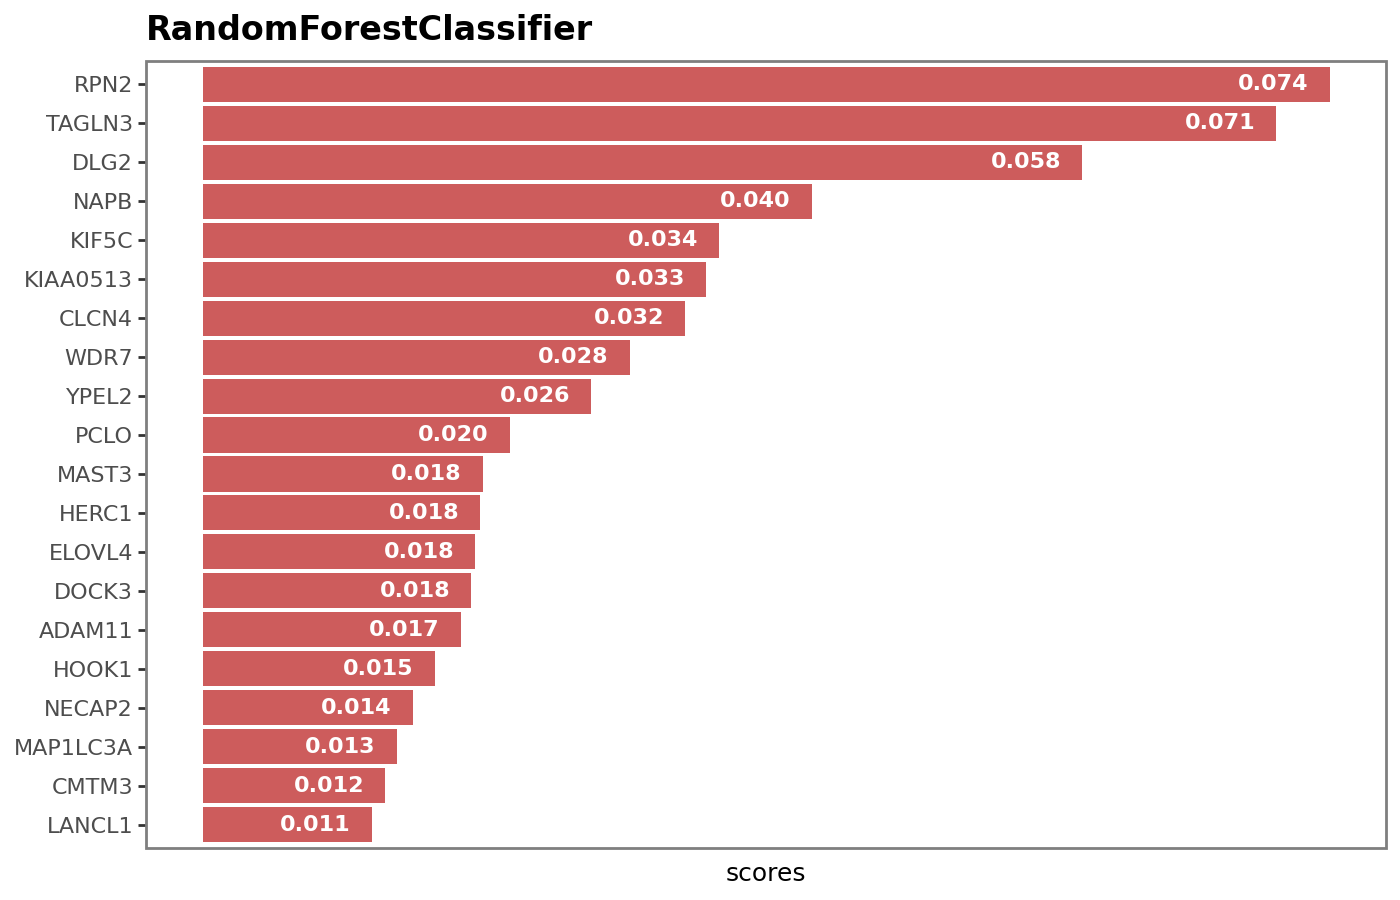

In [41]:
topn_importance(rf)

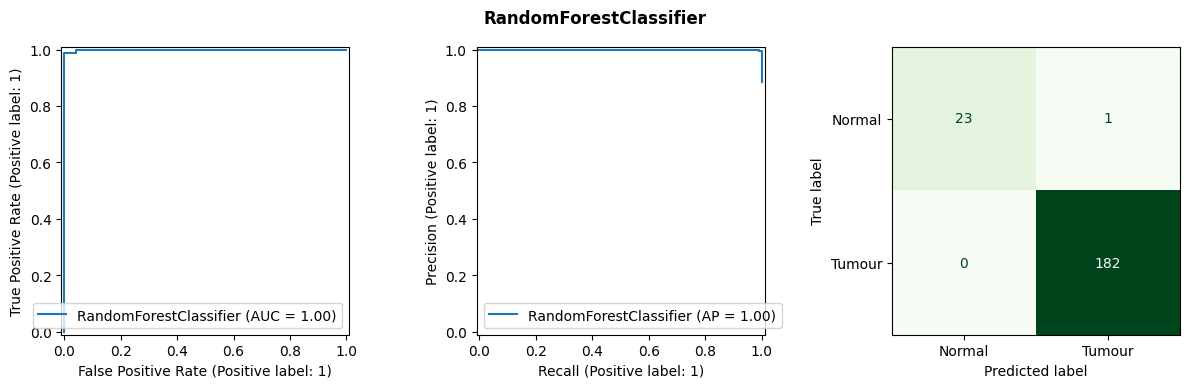

In [42]:
performance_chart_report(rf_res.best_estimator_, xtest[temp_features], ytest)

In [43]:
eval_metrics(rf_res, xtest[temp_features], ytest)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.995146,0.999542,1.0,0.994536,0.99726,0.958333


In [44]:
print_classification_report(rf, xtest[temp_features], ytest)

              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98        24
      Tumour       0.99      1.00      1.00       182

    accuracy                           1.00       206
   macro avg       1.00      0.98      0.99       206
weighted avg       1.00      1.00      1.00       206



__Common features selected by both logistic regression and random forests models__

In [45]:
common_genes = list(set(temp_features).intersection(lr_coefs.index))
print(pd.Index(sorted(common_genes)))

Index(['A2M', 'AATK', 'ANXA5', 'CCNJL', 'DPYSL3', 'FAM111A', 'GRIN1', 'HAT1',
       'KRT19', 'LARP6', 'NES', 'PLEKHA2', 'RASAL1', 'RBBP7', 'RPN2', 'RYBP',
       'SELE', 'SH3TC2', 'SSBP1', 'TPMT', 'UBE3A', 'UHRF1', 'YBX1'],
      dtype='object')
